# Timeseries visualizations of snow depth and others parameters et Tichki station (lat:31.53 ,lon:-6.30 ,alt:3260m ) over the period 2001-2010

## 1. Import python models

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import os 
import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import datetime as dt
import calendar as cld
import matplotlib.pyplot as plt
import xarray as xr
from os import listdir
from os.path import isfile, join
import cartopy.crs as ccrs
import cartopy 
import proplot as plot  # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import sys
import pymannkendall as mk
import calendar
import time
import matplotlib.image as mpimg
import plotly.express as px   
import datetime

## 2. Data wrangling and auxiliary functions

In [2]:
# The data files are xlsx file,  
path_snow_depth_data = '/home/hchaabani/snow_data/in_situ_sd/Draa_Mgoun'
tichki = pd.read_excel(path_snow_depth_data+"/Fulld_Tichki_Clean.xlsx")  

In [3]:
tichki.drop([0], axis=0, inplace=True)

In [4]:
tichki

ID        date    year  month   day  rh_2 at_2  net  rad  sut  ...  \
1     99.0  04.04.2001  2001.0    4.0   4.0    40  3.9  121  308  NaN  ...   
2     99.0  05.04.2001  2001.0    4.0   5.0    36  4.8   95  320  NaN  ...   
3     99.0  06.04.2001  2001.0    4.0   6.0    33  6.1   96  325  NaN  ...   
4     99.0  07.04.2001  2001.0    4.0   7.0    28  7.1  116  326  NaN  ...   
5     99.0  08.04.2001  2001.0    4.0   8.0    22  7.8   91  331  NaN  ...   
...    ...         ...     ...    ...   ...   ...  ...  ...  ...  ...  ...   
3559  99.0  31.12.2010  2010.0   12.0  31.0  21.7  0.5   17  166  1.5  ...   
3560  99.0  01.01.2011  2011.0    1.0   1.0  18.3  0.6   -5  165  2.3  ...   
3561  99.0  02.01.2011  2011.0    1.0   2.0  34.2  0.3   -1  151  2.1  ...   
3562  99.0  03.01.2011  2011.0    1.0   3.0  43.5  0.7    4  147  2.7  ...   
3563  99.0  04.01.2011  2011.0    1.0   4.0    47  0.7   -3  143  3.1  ...   

        dp at_2_min at_2_min_time at_2_max at_2_max_time wv_2_max  \
1      NaN     -0.5           605      8.3          1210     12.4   
2      NaN        0           620      9.8          1505     10.3   
3      NaN      1.8           455     11.6          1445      9.9   
4      NaN      2.8           525     12.5          1320     12.8   
5      NaN      3.4           415     12.6          1415      9.3   
...    ...      ...           ...      ...           ...      ...   
3559 -20.2     -2.9             0      6.3          1300       10   
3560 -23.3     -2.6           210      5.5          1230     14.4   
3561 -14.4     -2.1           710      4.9          1210     13.9   
3562 -10.7     -1.9          1845      4.5          1140      9.5   
3563  -9.6     -2.2           405      3.7          1220     10.9   

     wv_2_max_time rad_max rad_max_time batt_min  
1              434    1095         1147     12.9  
2             1543    1048         1205     12.9  
3             1800    1049         1218     12.9  
4             1317    1043         1151     12.9  
5             1315    1059         1219     12.9  
...            ...     ...          ...      ...  
3559           937     668         1213     12.8  
3560          2250     651         1207     12.8  
3561            43     839         1332     12.8  
3562          2341     716         1143     12.8  
3563            54     709         1239     12.8  

[3563 rows x 29 columns]

### We select the variables of interest

#### snd_corr : Snow depth in m
#### at_2 : air temperature at 2 m 
#### st-5 : soil temperature at 5cm depth
#### p : precipitation

In [5]:
tichki = tichki[["date", "snd_corr", "at_2", "st-5", "p"]]

In [6]:
tichki

date snd_corr at_2  st-5  p
1     04.04.2001        0  3.9   8.9  0
2     05.04.2001        0  4.8    10  0
3     06.04.2001        0  6.1    10  0
4     07.04.2001        0  7.1  10.6  0
5     08.04.2001        0  7.8  11.5  0
...          ...      ...  ...   ... ..
3559  31.12.2010        0  0.5   1.6  0
3560  01.01.2011        0  0.6   1.7  0
3561  02.01.2011        0  0.3   1.8  0
3562  03.01.2011        0  0.7   2.3  0
3563  04.01.2011        0  0.7   2.8  0

[3563 rows x 5 columns]

### Setting the date format and filling the missing dates with NaN value
#### Now we have to convert the date into a format suitable for panda objects and fill in the missing dates with NaN

In [13]:
tichki['aux_date'] = np.nan  
# For each dataframe, we fill the 'aux_date' column from coulumn 'date' ('d/m/y to y-m-d')
for l in range(len(tichki)):   
    tichki['aux_date'][l+1] = tichki['date'][l+1][6:10] +'-'+ tichki['date'][l+1][3:5] +'-'+ tichki['date'][l+1][0:2]

/tmp/ipykernel_81783/1862171370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tichki['aux_date'] = np.nan
/tmp/ipykernel_81783/1862171370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tichki['aux_date'][l+1] = tichki['date'][l+1][6:10] +'-'+ tichki['date'][l+1][3:5] +'-'+ tichki['date'][l+1][0:2]


In [14]:
tichki['aux_date'] = pd.to_datetime(tichki['aux_date'], format='%Y-%m-%d')

/tmp/ipykernel_81783/1273674471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tichki['aux_date'] = pd.to_datetime(tichki['aux_date'], format='%Y-%m-%d')


In [15]:
tichki.set_index('aux_date', inplace=True)

In [17]:
idx = pd.date_range('04/04/2001', '31/12/2010')
for i in range(4):                                       
    tichki = tichki.reindex(idx, fill_value=np.nan)

In [18]:
tichki

date snd_corr at_2  st-5  p
2001-04-04  04.04.2001        0  3.9   8.9  0
2001-04-05  05.04.2001        0  4.8    10  0
2001-04-06  06.04.2001        0  6.1    10  0
2001-04-07  07.04.2001        0  7.1  10.6  0
2001-04-08  08.04.2001        0  7.8  11.5  0
...                ...      ...  ...   ... ..
2010-12-27  27.12.2010        0  2.7   1.4  0
2010-12-28  28.12.2010        0 -0.1     2  0
2010-12-29  29.12.2010        0 -0.5     2  0
2010-12-30  30.12.2010        0 -2.8   0.9  0
2010-12-31  31.12.2010        0  0.5   1.6  0

[3559 rows x 5 columns]

### An auxiliary function 

In [19]:
# This auxiliary function will help us in the formatting of the figures
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

## 3. Timeseries visualizations

### Snow depth, air temperature, surface temperature and precipitations time series 

(-10.0, 30.0)

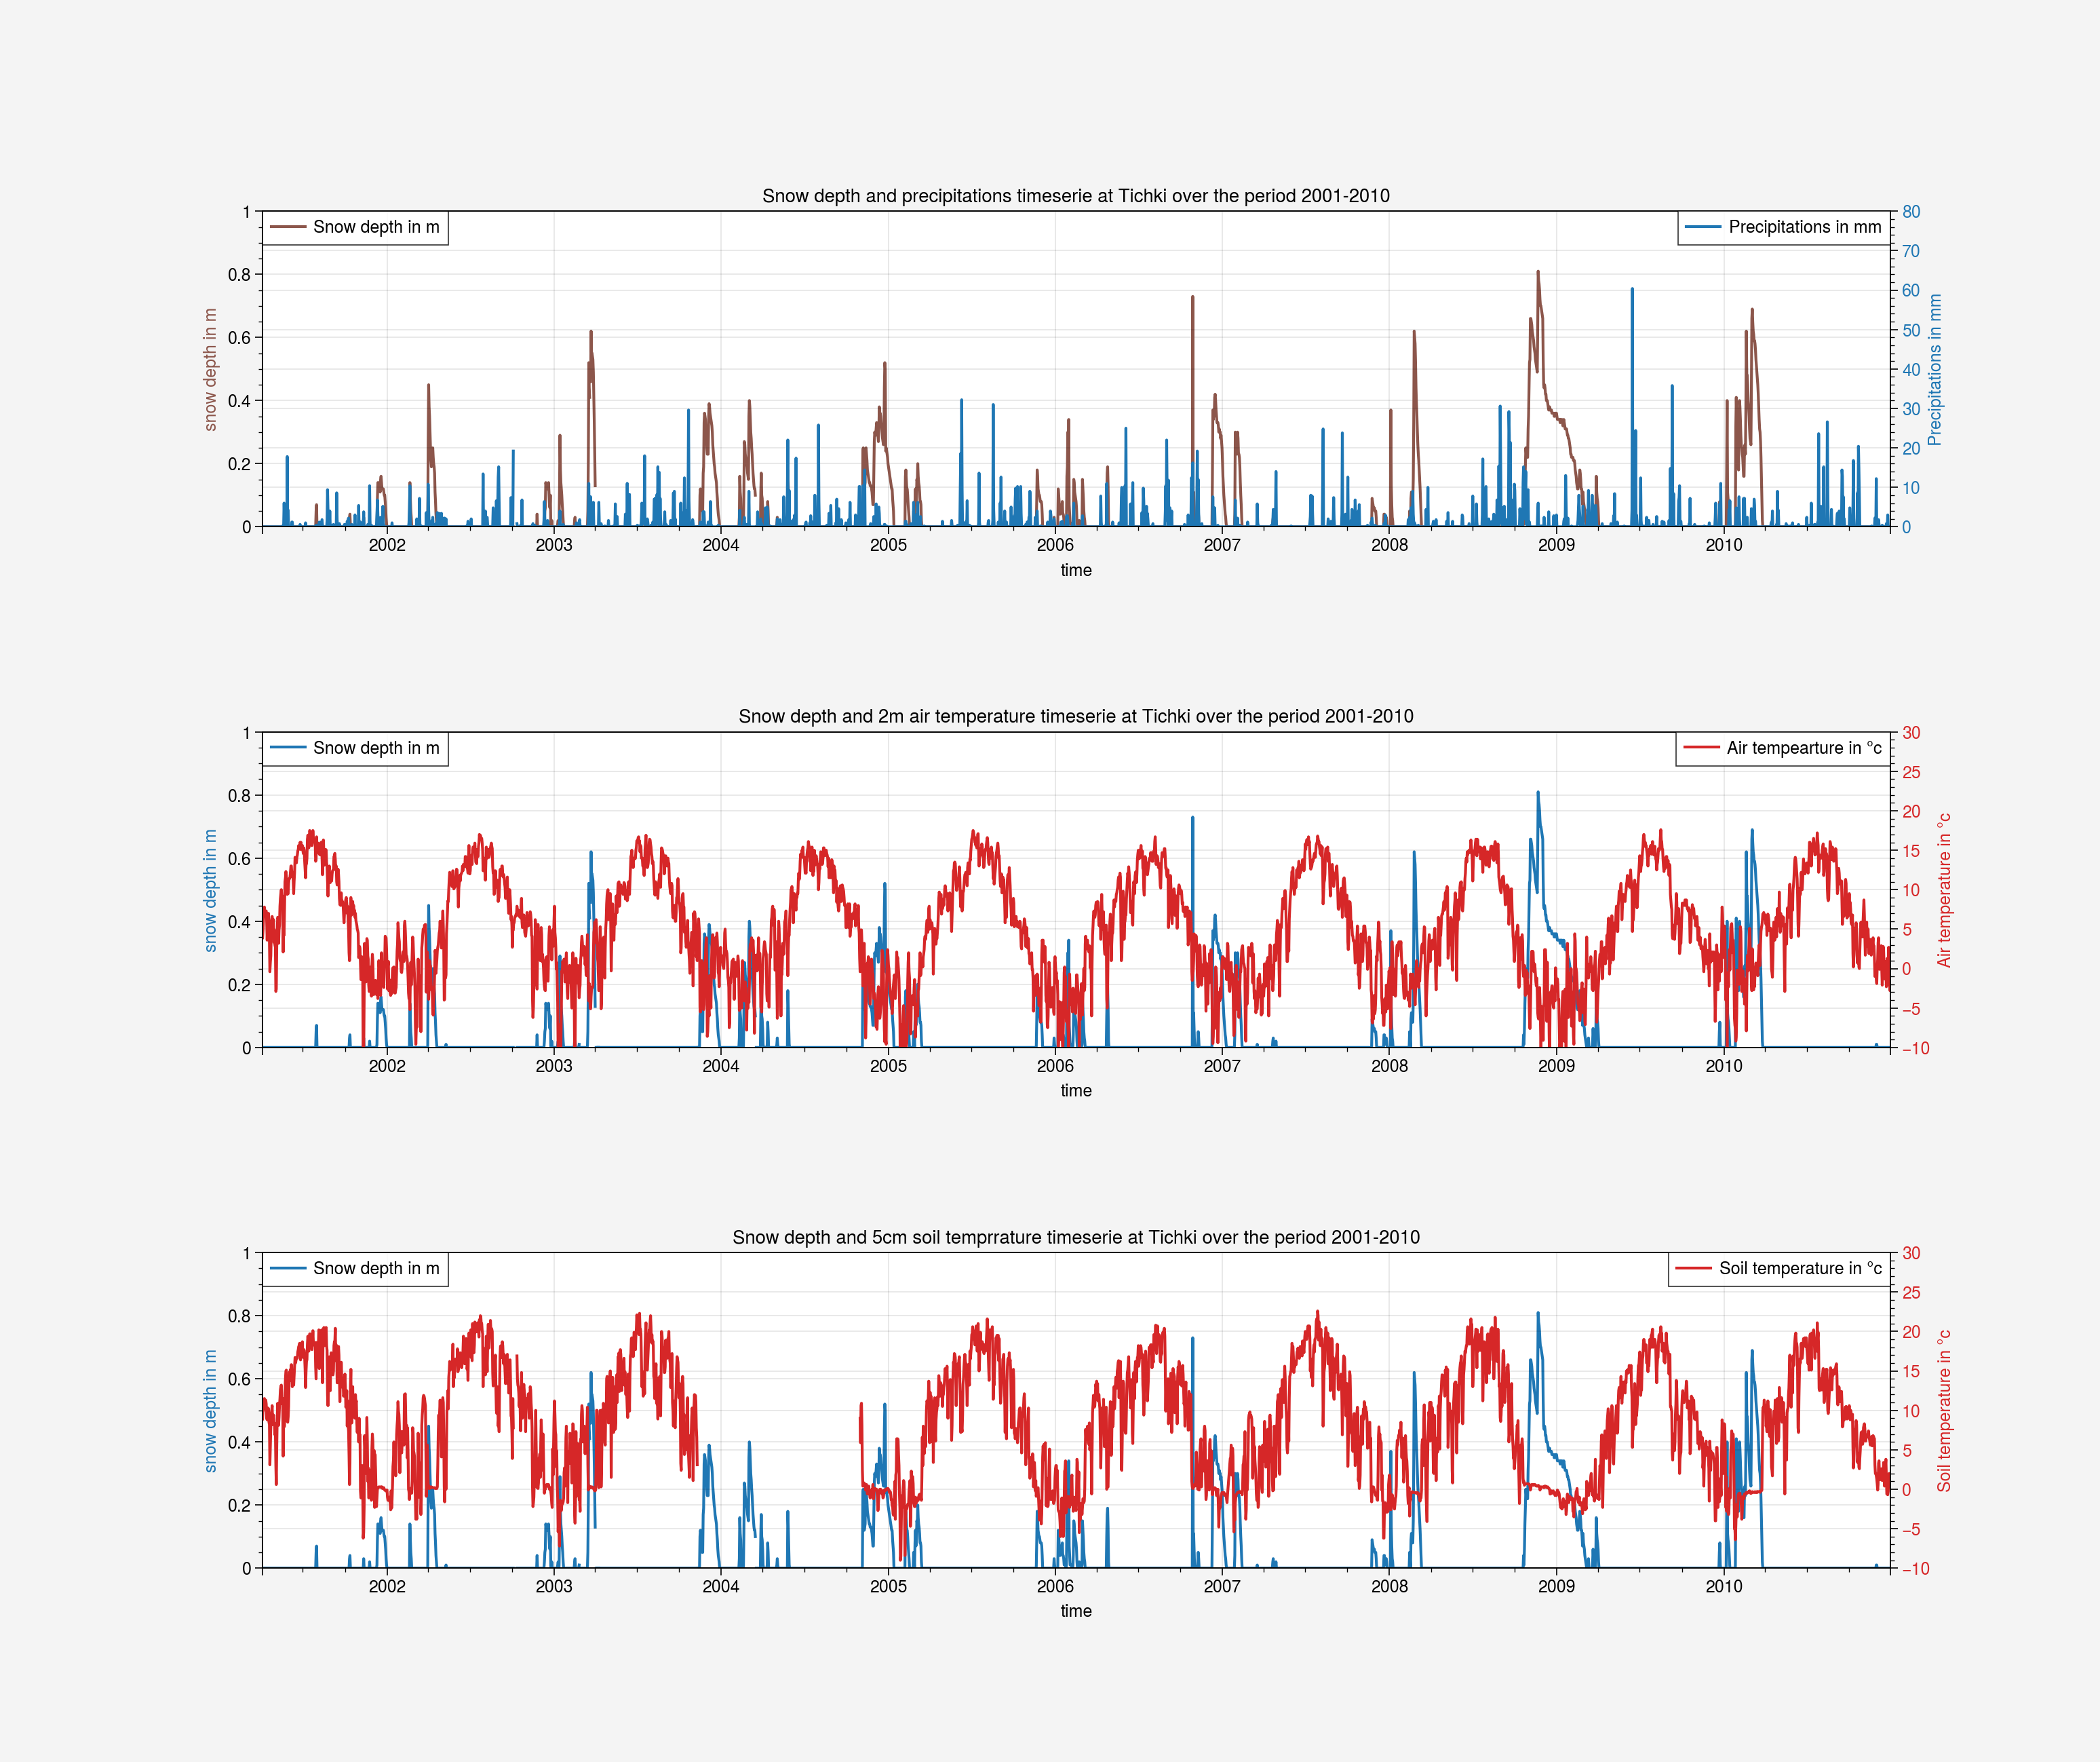

In [81]:
Noms=["Tichki (3260m)"]
fig, axs=plt.subplots(3, 1) 
# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.1,hspace=0.65)

# We fix the size of figure
set_size(12,10)


color = 'tab:brown'
tichki['snd_corr'].plot(ax=axs[0], ylim=[0,1], color=color) 
axs[0].set_title("Snow depth and precipitations timeserie at Tichki over the period 2001-2010")
axs[0].set_xlabel("time") 
axs[0].legend(labels = ["Snow depth in m"], loc='upper left')
axs[0].set_ylabel("snow depth in m", color=color) 
axs[0].set_ylim(0,1)

ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'  
ax2.set_ylabel('Precipitations in mm', color=color)  # we already handled the x-label with ax1
tichki['p'].plot(ax=ax2, ylim=[0,80], color=color) 
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(labels = ["Precipitations in mm"], loc='upper right')
ax2.set_ylim(0,80)

# =============================================================================================

color = 'tab:blue'
tichki['snd_corr'].plot(ax=axs[1], ylim=[0,1], color=color) 
axs[1].set_title("Snow depth and 2m air temperature timeserie at Tichki over the period 2001-2010")
axs[1].set_xlabel("time") 
axs[1].legend(labels = ["Snow depth in m"], loc='upper left')
axs[1].set_ylabel("snow depth in m", color=color) 
axs[1].set_ylim(0,1)

ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'  
ax2.set_ylabel('Air temperature in °c', color=color)  # we already handled the x-label with ax1
tichki['at_2'].plot(ax=ax2, ylim=[-10,30], color=color) 
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(labels = ["Air tempearture in °c"], loc='upper right')
ax2.set_ylim(-10,30)

# =============================================================================================

color = 'tab:blue'
tichki['snd_corr'].plot(ax=axs[2], ylim=[0,1], color=color) 
axs[2].set_title("Snow depth and 5cm soil temprrature timeserie at Tichki over the period 2001-2010")
axs[2].set_xlabel("time") 
axs[2].legend(labels = ["Snow depth in m"], loc='upper left')
axs[2].set_ylabel("snow depth in m", color=color) 
axs[2].set_ylim(0,1)

ax2 = axs[2].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'  
ax2.set_ylabel('Soil temperature in °c', color=color)  # we already handled the x-label with ax1
tichki['st-5'].plot(ax=ax2, ylim=[-10,30], color=color) 
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(labels = ["Soil temperature in °c"], loc='upper right')
ax2.set_ylim(-10,30)

### Snow depth and precipitations timeserie at Tichki during the hydrological years of the period 2001-2010

In [69]:
years=["2001-2002","2002-2003","2003-2004","2004-2005","2005-2006","2006-2007","2007-2008", "2008-2009", "2009-2010"]

fig, axs=plt.subplots(9,1)         
plt.subplots_adjust(wspace=0.2,hspace=0.65)
set_size(10,18)


year = 2001
for i in range(9):
    color = 'tab:brown'
    tichki['snd_corr'][str(year)+'-09-01':str(year+1)+'-08-31'].plot(ax=axs[i], ylim=[0,1], color=color) 
    axs[i].set_title("Snow depth and precipitations timeserie at Tichki during the hydrological year "+years[i])
    axs[i].set_xlabel("time")  
    axs[i].set_ylabel("snow depth in m") 
    axs[i].legend(labels = ["Snow depth in m"], loc='upper left')
    axs[i].set_ylabel("snow depth in m", color=color) 
    axs[i].set_ylim(0,1)

    ax2 = axs[i].twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Precipitations in mm', color=color)  # we already handled the x-label with ax1
    tichki['p'][str(year)+'-09-01':str(year+1)+'-08-31'].plot(ax=ax2, ylim=[0,65], color=color) 
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(labels = ["Precipitations in mm"], loc='upper right')
    ax2.set_ylim(0,65)
    
    year=year+1    

### Snow depth and 2m air temperature timeserie at Tichki during the hydrological years of the period 2001-2010

In [73]:
years=["2001-2002","2002-2003","2003-2004","2004-2005","2005-2006","2006-2007","2007-2008", "2008-2009", "2009-2010"]

fig, axs=plt.subplots(9,1)         
plt.subplots_adjust(wspace=0.2,hspace=0.65)
set_size(10,18)


year = 2001
for i in range(9):
    color = 'tab:blue'
    tichki['snd_corr'][str(year)+'-09-01':str(year+1)+'-08-31'].plot(ax=axs[i], ylim=[0,1], color=color) 
    axs[i].set_title("Snow depth and air temperature timeserie at Tichki during the hydrological year"+years[i])
    axs[i].set_xlabel("time")  
    axs[i].set_ylabel("snow depth in m") 
    axs[i].legend(labels = ["Snow depth in m"], loc='center right')
    axs[i].set_ylabel("snow depth in m", color=color) 
    axs[i].set_ylim(0,1)

    ax2 = axs[i].twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('2m air temperature in °c', color=color)  # we already handled the x-label with ax1
    tichki['at_2'][str(year)+'-09-01':str(year+1)+'-08-31'].plot(ax=ax2, ylim=[15,20], color=color) 
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(labels = ["2m air temperature in °c"], loc='lower right')
    ax2.set_ylim(-15,20)
    
    year=year+1    

### Snow depth and 5cm soil temperature timeserie at Tichki during the hydrological years of the period 2001-2010

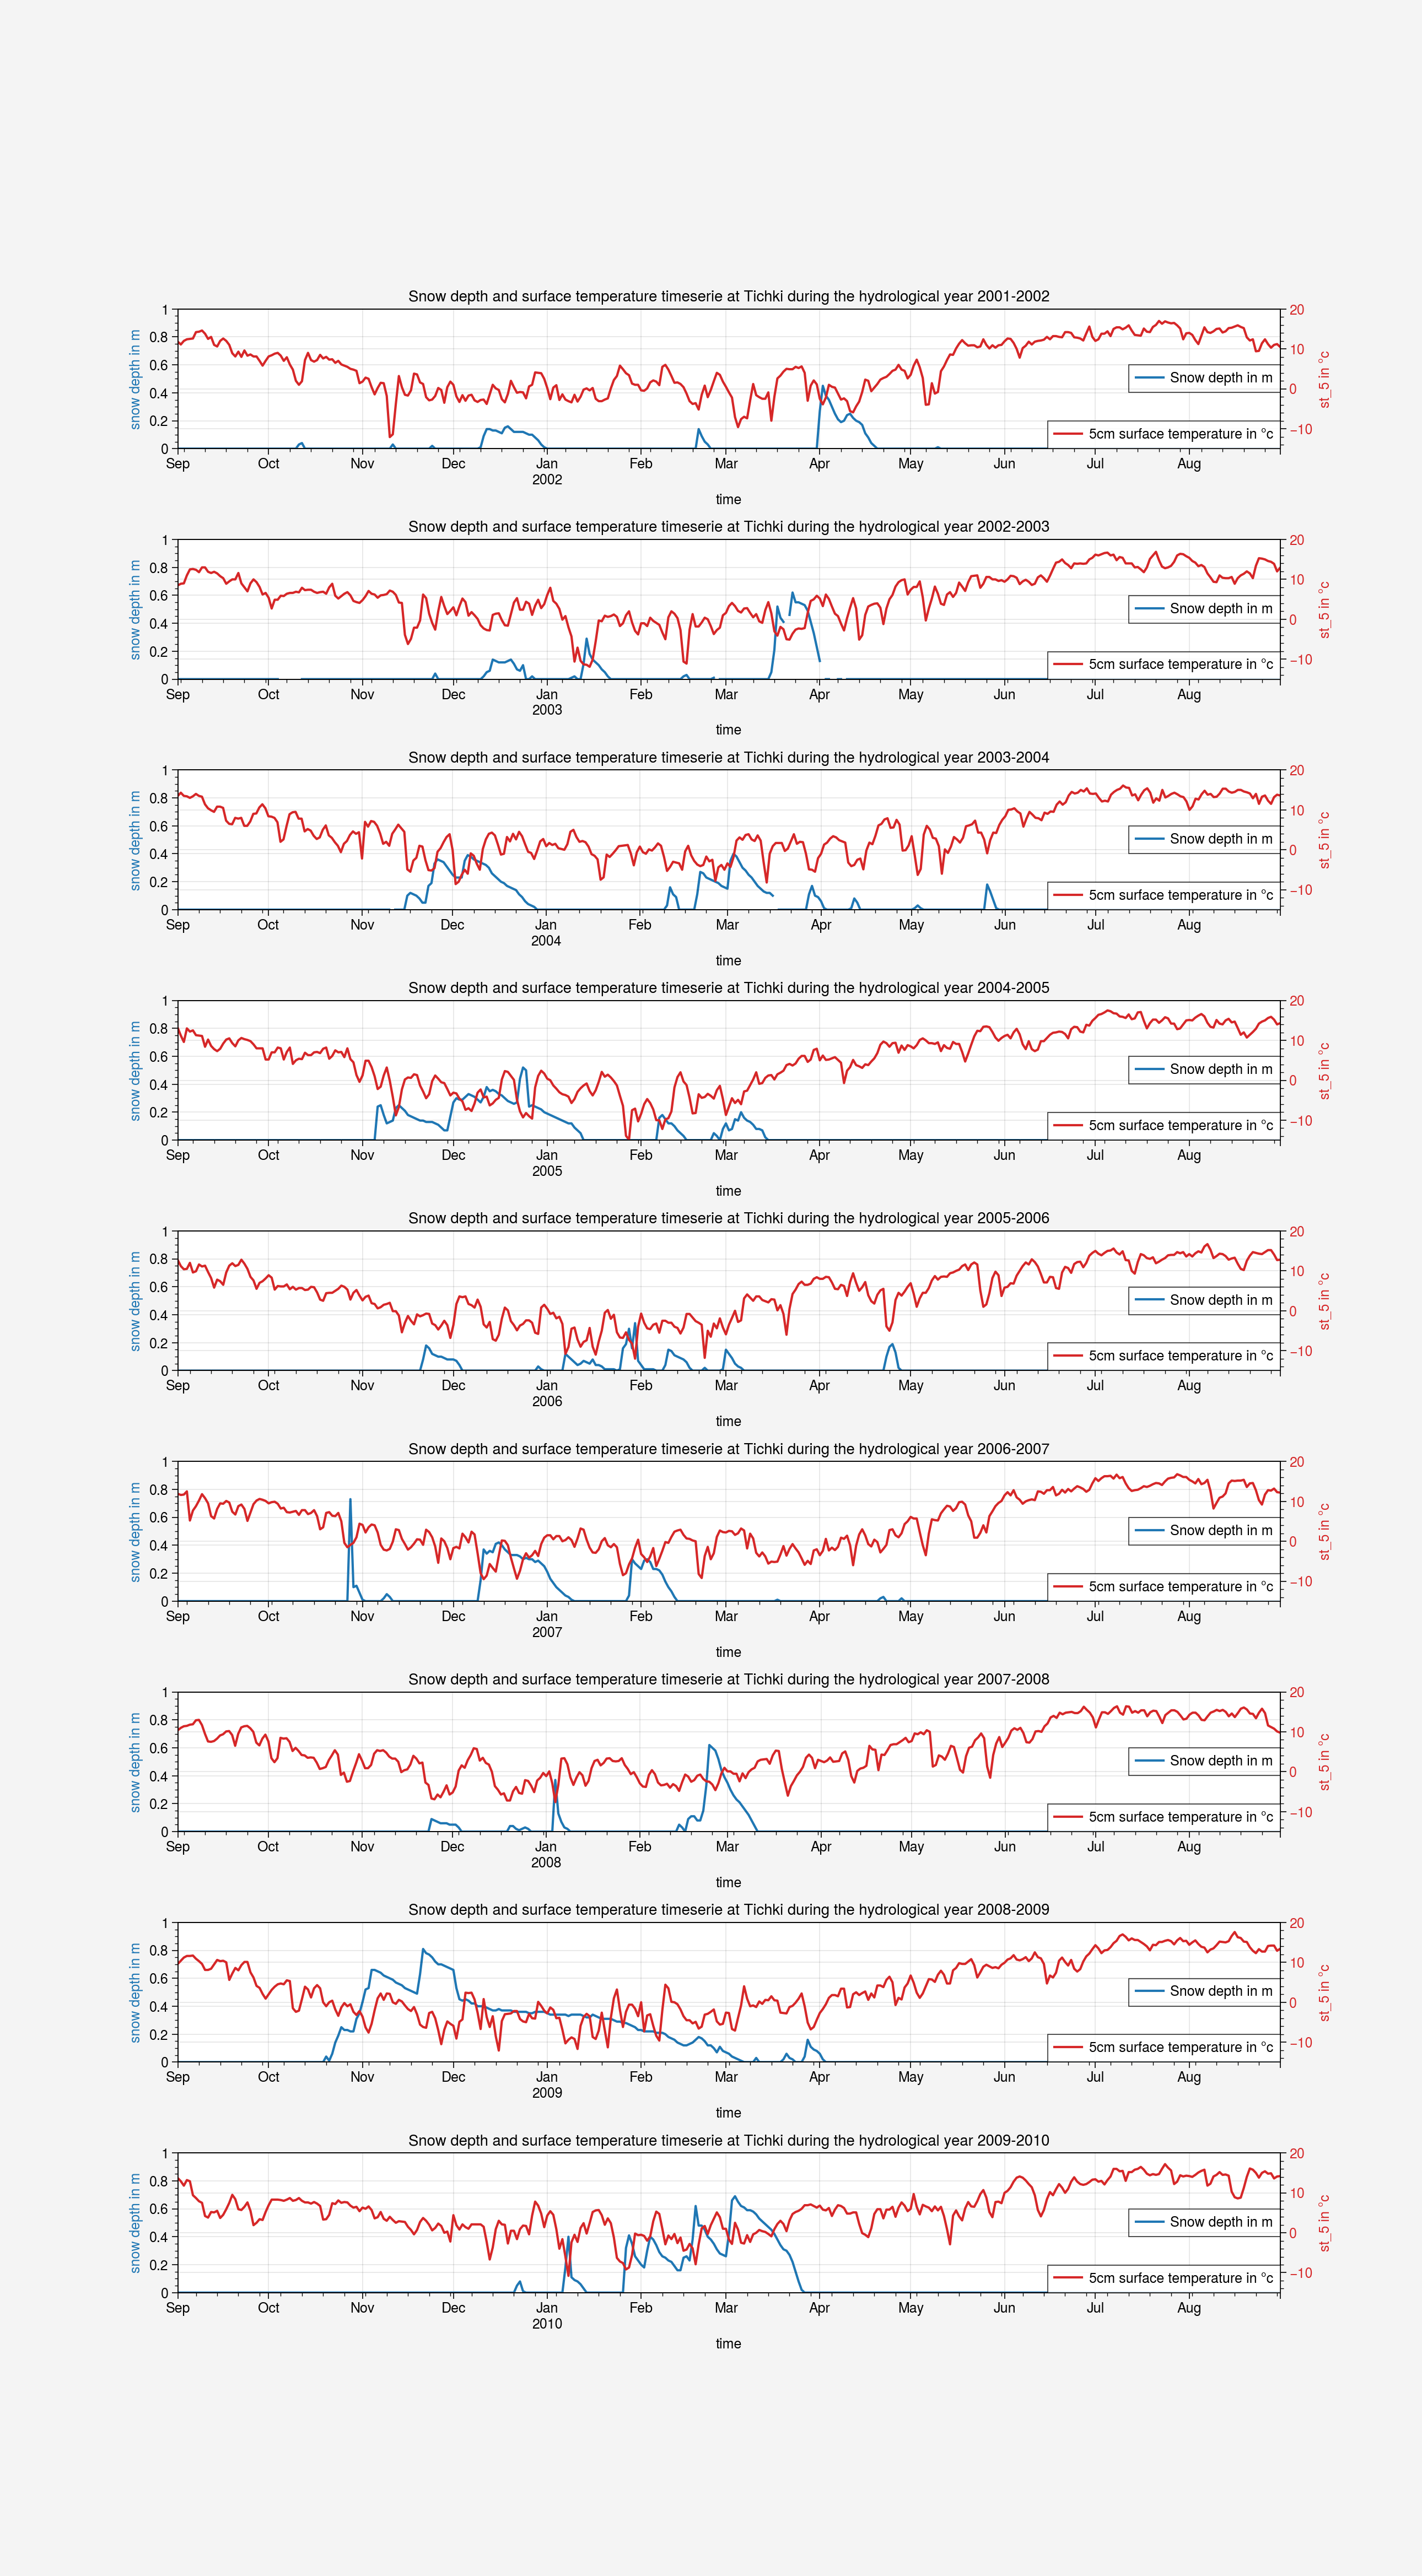

In [74]:
years=["2001-2002","2002-2003","2003-2004","2004-2005","2005-2006","2006-2007","2007-2008", "2008-2009", "2009-2010"]

fig, axs=plt.subplots(9,1)         
plt.subplots_adjust(wspace=0.2,hspace=0.65)
set_size(10,18)


year = 2001
for i in range(9):
    color = 'tab:blue'
    tichki['snd_corr'][str(year)+'-09-01':str(year+1)+'-08-31'].plot(ax=axs[i], ylim=[0,1], color=color) 
    axs[i].set_title("Snow depth and surface temperature timeserie at Tichki during the hydrological year "+years[i])
    axs[i].set_xlabel("time")  
    axs[i].set_ylabel("snow depth in m") 
    axs[i].legend(labels = ["Snow depth in m"], loc='center right')
    axs[i].set_ylabel("snow depth in m", color=color) 
    axs[i].set_ylim(0,1)

    ax2 = axs[i].twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('st_5 in °c', color=color)  # we already handled the x-label with ax1
    tichki['at_2'][str(year)+'-09-01':str(year+1)+'-08-31'].plot(ax=ax2, ylim=[-15,20], color=color) 
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(labels = ["5cm surface temperature in °c"], loc='lower right')
    ax2.set_ylim(-15,20)
    
    year=year+1    